# Sentiment Analysis from Tweets (Basic)

This notebook involves implementing functions for a text classifier, which will be trained to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split. 

In [1]:
#importing necessary packages
import csv
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from nltk.classify import SklearnClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support # to report on precision and recall

In [2]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

## Input and Basic preprocessing

In [3]:
def parse_data_line(data_line):
    """Given a tab separated line, returns a tuple containing label and statement."""
    label = data_line[1]
    statement = data_line[2]
    return (label, statement)

In [4]:
#Pre-processing
def pre_process(text):
    """Separates punctuation from the text and splits the text into words."""
    
    #separating punctuation at the end 
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
    
    #separating punctuation at the begining
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
    
    #tokenisation 
    tokens = re.split(r"\s+",text)
    
    return tokens

The first stage of data handling involves extraction of statements and their corresponding sentiment labels. This involves iterating through each line of the tab-separated dataset, extracting sentiment labels from the second index and the respective statements from the third index of the data lines, structuring them in the form of a tuple which is used for further processes.
Following this, initial data pre-processing is done on the statements. This includes separating punctuations from the text, breaking down the sentences into words based on white-space i.e tokenization of the text.

## Basic Feature Extraction

In [5]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    """Returns a dictionary containing list of word indices (keys) and it's weight (values) 
    corresponding to the frequency of its occurence in the document"""
    
    feature_vector = {}
    for word in tokens:
        #checks if word is present in global dictionary, if it is present the index of the word is retrieved
        if word in global_feature_dict:
            i = global_feature_dict[word]
        else:
            #else the word is added to the global dictionary with an index
            i = len(global_feature_dict)+1
            global_feature_dict[word]=i
            #checks if the index is present in local dictionary, if it is present, more weight is added to the word(repeated word)
        if i in feature_vector:
            feature_vector[i] +=1
        else:
            #else the word is assigned weight 1 (bag of words)
            feature_vector[i]=1
    return feature_vector

In [6]:
# TRAINING AND VALIDATING OUR CLASSIFIER
def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(dual=True))])
    return SklearnClassifier(pipeline).train(data)

In this phase, the features are extracted using a bag-of-words approach which involves creating a dictionary where each unique word serves as a key, and its frequency of occurrence acts as the corresponding value. A global feature dictionary that keeps track of all the feature names in the dataset is created.
As the pre-processed text is iterated through, each word is verified within the global dictionary. If the word is found, its index is retrieved, and its weight is incremented by 1 within the feature vector. If the word is not present, a new index is created for it.

## Cross-validation

The implemented cross validation method follows a k-fold approach where k=10. The dataset is split into a 80%/20% training/test split and the 80% training data is separated again into 10 folds where each fold has 90% training and 10% test data. The LinearSVC classifier is trained on the training subset of each fold and the sentiment labels for each fold are predicted. The evaluation metrics, including precision, recall, F1 score, and accuracy, were computed for each fold individually, offering a granular insight into the classifier's performance across different folds of the dataset.


In [7]:
results = []
global best_fold_data #dictionary to save best fold data for error analysis

best_fold_data = { 'max_accuracy': float('-inf') }

def cross_validate(dataset, folds):
    """Performs k-fold cross validation on dataset and returns the average scores of all folds"""

    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Folds start on items %d - %d" % (i, i+fold_size))
        
        # Splitting data into train and test for this fold
        test_data = dataset[i:i + fold_size]
        train_data = dataset[:i] + dataset[i + fold_size: len(dataset)]
        
        # Training the classifier
        classifier = train_classifier(train_data)
        
        # Predicting labels on test set
        test_text = [data[0] for data in test_data]
        test_labels = [data[1] for data in test_data]
        predicted_labels = predict_labels(test_text, classifier)
        
        #calculating metrics for the fold
        fold_classification_report = classification_report(test_labels, predicted_labels, output_dict=True)
        
        #save data of the best fold for error analysis
        if(fold_classification_report['accuracy'] > best_fold_data['max_accuracy']):
            best_fold_data['cv_test_text'] = test_text
            best_fold_data['test_start_index']=i
            best_fold_data['fold_size']=fold_size
            best_fold_data['cv_test_labels'] = test_labels
            best_fold_data['cv_predicted_labels'] = predicted_labels
            best_fold_data['max_accuracy'] = fold_classification_report['accuracy']

        #appending metrics to result variable
        results.append({
        'Accuracy': fold_classification_report['accuracy'],
        'Precision': fold_classification_report['weighted avg']['precision'],
        'Recall': fold_classification_report['weighted avg']['recall'],
        'F1 Score': fold_classification_report['weighted avg']['f1-score']
        })
        
        #print accuracy of each fold
        print("Accuracy: " ,fold_classification_report['accuracy'])
        
    metrics = pd.DataFrame(results)
    
    return metrics.mean()

In [8]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [9]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 
print(raw_data[24])
# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)
print(train_data[24])
# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
('waww,, I wanna have it RT @ElmiraGriswold3 @Vah_Raflatahugs wow,ipad got just today free lol www.burna.in/fgye', 'positive')
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
({359: 1, 360: 1, 4: 1, 361: 1, 31: 1, 42: 1, 362: 1, 363: 1, 364: 1, 365: 1, 19: 1, 366: 1, 135: 1, 286: 1, 367: 1, 368: 1, 369: 1, 370: 1, 17: 2, 371: 1, 372: 1}, 'positive')
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
75778


In [10]:
#check pre processed data
print("Data after pre-processing")
print(pre_process(raw_data[24][0]))

Data after pre-processing
['waww', ',,', 'I', 'wanna', 'have', 'it', 'RT', '@ElmiraGriswold3', '@Vah_Raflatahugs', 'wow', ',', 'ipad', 'got', 'just', 'today', 'free', 'lol', 'www', '.', 'burna', '.', 'in/fgye']


In [11]:
#Cross validation
print("10 fold Cross Validation on training data")
cv_results = cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

10 fold Cross Validation on training data
Folds start on items 0 - 2684
Training Classifier...
Accuracy:  0.8472429210134128
Folds start on items 2684 - 5368
Training Classifier...
Accuracy:  0.8524590163934426
Folds start on items 5368 - 8052
Training Classifier...
Accuracy:  0.8140834575260805
Folds start on items 8052 - 10736
Training Classifier...
Accuracy:  0.8256333830104322
Folds start on items 10736 - 13420
Training Classifier...
Accuracy:  0.8368107302533532
Folds start on items 13420 - 16104
Training Classifier...
Accuracy:  0.8528315946348733
Folds start on items 16104 - 18788
Training Classifier...
Accuracy:  0.8442622950819673
Folds start on items 18788 - 21472
Training Classifier...
Accuracy:  0.8379284649776453
Folds start on items 21472 - 24156
Training Classifier...
Accuracy:  0.8453800298062594
Folds start on items 24156 - 26840
Training Classifier...
Accuracy:  0.8501494768310912


Average scores across all folds
Accuracy     0.840678
Precision    0.839388
Recall       0.840678
F1 Score     0.839709
dtype: float64


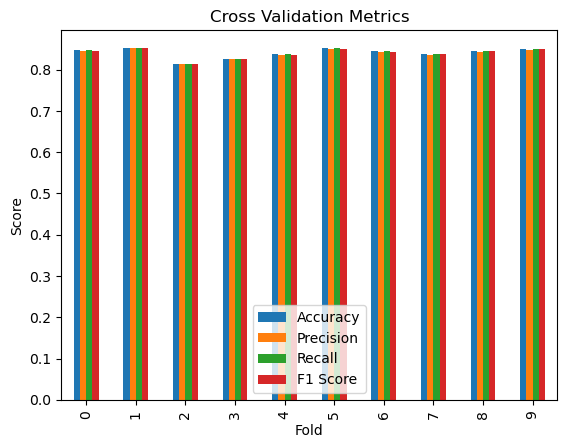

In [12]:
print("Average scores across all folds")
print(cv_results)

# plot the results
fold_metrics = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
fold_metrics.plot(kind='bar', ylabel='Score', xlabel='Fold', title='Cross Validation Metrics')
plt.show()

The mean of these metrics was then calculated owing to the overall accuracy of the model across all folds as 84%. In this 10 fold cross validation approach, k=5 fold had the highest weighted average accuracy of 85.28%.

## Error Analysis

In [13]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [14]:
def error_analysis():
    """Displays classification report, confusion matrix for the best fold in cross validation step. 
    Prints out the errors to a csv file"""
    
    #fetching the starting index of test data of the best fold
    k = best_fold_data['test_start_index']

    #display the results
    print("Accuracy: ", best_fold_data['max_accuracy'])
    print(classification_report(best_fold_data['cv_test_labels'], best_fold_data['cv_predicted_labels']))
    confusion_matrix_heatmap(best_fold_data['cv_test_labels'], best_fold_data['cv_predicted_labels'], ["negative", "positive"])

    #write errors to csv file
    with open('./error_analysis_tweets.csv', 'w') as f:
        writer = csv.writer(f)

        #heading
        writer.writerow(['Index', 'Text', 'Label', 'Prediction'])

        #false negatives
        writer.writerow(['False Negatives'])
        index = 1
        for i in range(len(best_fold_data['cv_predicted_labels'])):
            if best_fold_data['cv_predicted_labels'][i] == 'negative' and best_fold_data['cv_test_labels'][i] == 'positive':
                writer.writerow([index,raw_data[k+i][0], best_fold_data['cv_test_labels'][i], best_fold_data['cv_predicted_labels'][i]])
                index += 1

        #false positives
        writer.writerow(['False Positives'])
        index = 1
        for i in range(len(best_fold_data['cv_predicted_labels'])):
            if best_fold_data['cv_predicted_labels'][i] == 'positive' and best_fold_data['cv_test_labels'][i] == 'negative':
                writer.writerow([index,raw_data[k+i][0], best_fold_data['cv_test_labels'][i], best_fold_data['cv_predicted_labels'][i]])
                index += 1

Metrics of the best fold data
Accuracy:  0.8528315946348733
              precision    recall  f1-score   support

    negative       0.81      0.75      0.78       931
    positive       0.87      0.91      0.89      1753

    accuracy                           0.85      2684
   macro avg       0.84      0.83      0.83      2684
weighted avg       0.85      0.85      0.85      2684



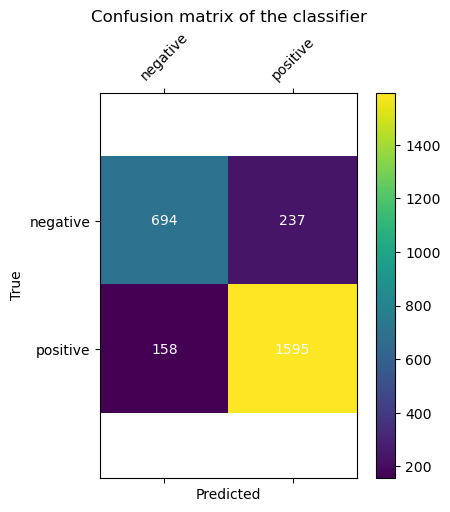

In [15]:
#Perform error analysis
print("Metrics of the best fold data")
error_analysis()

In [16]:
#display the error file
csvcheck = pd.read_csv('./error_analysis_tweets.csv')
csvcheck.head()

,Index,Text,Label,Prediction
0,False Negatives,NaN,NaN,NaN
1,1,I may not seem like the target demographic but...,positive,negative
2,2,@TimWelcomed Since there is a WWE Games group ...,positive,negative
3,3,@OsoFreshFutbol I think the expectations are s...,positive,negative
4,4,saw david beckham on david blaine's tv special...,positive,negative


Based on the confusion matrix, the model misclassified 237 negative instances as positive and classified 158 instances as negative instead of positive. The number of false positives is higher than false negatives implying that missing negative sentiment (FP) occurs more frequently than misclassifying positive sentiment as negative (FN). Even though the overall accuracy of the model for the fold entails 85.2%, the precision and recall is higher for positive sentiment than negative sentiment. While the classifier model effectively detects positive tweets with 87% precision and 91% recall, it faces challenges in identifying negative sentiment (81% precision and 75% recall), indicating that the model captures only 75% of the actual negative tweets.
For instance, the misclassification of the statement ‘@PaulMerse Are you on drugs? You're deluded if you think Arsenal will finish 3rd. I expected your Spurs prediction. #Speaktofrank #Deluded’ as positive might stem from noise in the data, suggesting the need for improvements in the areas of data pre-processing and feature engineering to refine the model's understanding of negative sentiment.

## Training and Evaluation

In [17]:
# Finally, check the accuracy of the classifier by training on all the training data
# and testing on the test set
functions_complete = True 
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({1522: 1, 237: 1, 5: 2, 807: 2, 1131: 1, 59: 2, 35354: 1, 100: 1, 58: 1, 65061: 1, 65062: 1, 303: 1, 1051: 1, 65063: 1, 114: 2, 420: 1, 182: 1, 158: 1, 22397: 1, 23: 1, 3079: 1}, 'positive')
Training Classifier...
Done training!
Precision: 0.842770
Recall: 0.844216
F Score:0.843195
